# Challenge 1

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running on Kaggle


Import required libraries

In [22]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [23]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


Define some useful constants.

In [24]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

Set the manual seed.

In [25]:
torch.manual_seed(42)

Extend **Dataset** class for the **DatasetLoader** (define a mapping for images and labels).

In [26]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, transform_minority=None, target_transform=None, equalize=False):
        self.equalize = equalize
        if self.equalize:
            self.img_labels = self.equalize_dataset(annotations_file)
        else:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.transform_minority = transform_minority

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            if label == 1:
                image = self.transform(image)
            else:
                image = self.transform_minority(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def equalize_dataset(self, file):
        df = pd.read_csv(file)
        filtered_rows = df[df['has_cactus']==0]
        df = pd.concat([df, filtered_rows], ignore_index=True)
        df = pd.concat([df, filtered_rows], ignore_index=True)
        return df

TODO: Try to preprocess like in ImProc

Instanciate a **Dataset** object on the training (+validation) data.

In [27]:
# Imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

In [28]:
import torchvision.transforms as transforms

# Transformation for the image data
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])
transform_minority = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=np.random.uniform(0,30)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
    
])

In [29]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform, transform_minority=transform_minority, equalize=True)

In [30]:
# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


Split the dataset into train + validation

In [31]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 20982
Validation set size: 5246


Let's define our first model.\
We are going to use the ResNet18 pretrained model and then we are going to add 1 linear FC output layer. The output will be a real value that we will feed into a Sigmoid function to squash it into the $[0, 1]$ interval, and we will do the classification by comparing the output of the Sigmoid with the $0.5$ treshold.\
Since we don't want to adjust ResNet18 weights, we are going to set the **requires_grad** property to **False** for each of its parameters.

In [32]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetClassificator(nn.Module):
    def __init__(self, fc_size=None):
        super(ResnetClassificator, self).__init__()
        
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        
        self.resnet = resnet
        self.fc_size = 1 if fc_size is None or fc_size < 2 else fc_size
        if self.fc_size < 2:
            self.fc1 = nn.Linear(resnet.fc.out_features, 1)
        else:
            self.fc1 = nn.Linear(resnet.fc.out_features, fc_size)
            self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        if self.fc_size != 1:
            x = self.fc2(x)
        return x

At this point, let's train our model.

In [33]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [34]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [35]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    tp, fp, fn = 0, 0, 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5
            errors += pred != y
            tp += ((pred == 1) & (y == 1)).sum().item()
            fp += ((pred == 1) & (y == 0)).sum().item()
            fn += ((pred == 0) & (y == 1)).sum().item()

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    return avg_val_loss, errors, f1


In [36]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [38]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1004 - Val Loss: 0.1404 - Error Rate: 0.0488 - F1 score : 0.9539


Epoch 2/100	 Train Loss: 0.0460 - Val Loss: 0.0303 - Error Rate: 0.0101 - F1 score : 0.9899


Epoch 3/100	 Train Loss: 0.0400 - Val Loss: 0.0228 - Error Rate: 0.0067 - F1 score : 0.9934


Epoch 4/100	 Train Loss: 0.0316 - Val Loss: 0.0187 - Error Rate: 0.0063 - F1 score : 0.9938


Epoch 5/100	 Train Loss: 0.0257 - Val Loss: 0.0106 - Error Rate: 0.0038 - F1 score : 0.9962


Epoch 6/100	 Train Loss: 0.0205 - Val Loss: 0.0191 - Error Rate: 0.0071 - F1 score : 0.9930


Epoch 7/100	 Train Loss: 0.0178 - Val Loss: 0.0142 - Error Rate: 0.0040 - F1 score : 0.9960


Epoch 8/100	 Train Loss: 0.0159 - Val Loss: 0.0160 - Error Rate: 0.0065 - F1 score : 0.9936


Epoch 9/100	 Train Loss: 0.0126 - Val Loss: 0.0121 - Error Rate: 0.0044 - F1 score : 0.9957


Epoch 10/100	 Train Loss: 0.0134 - Val Loss: 0.0162 - Error Rate: 0.0055 - F1 score : 0.9945


Epoch 11/100	 Train Loss: 0.0121 - Val Loss: 0.0149 - Error Rate: 0.0063 - F1 score : 0.9938


Epoch 12/100	 Train Loss: 0.0109 - Val Loss: 0.0134 - Error Rate: 0.0050 - F1 score : 0.9951


Epoch 13/100	 Train Loss: 0.0109 - Val Loss: 0.0158 - Error Rate: 0.0050 - F1 score : 0.9951


Epoch 14/100	 Train Loss: 0.0091 - Val Loss: 0.0058 - Error Rate: 0.0017 - F1 score : 0.9983


Epoch 15/100	 Train Loss: 0.0042 - Val Loss: 0.0146 - Error Rate: 0.0048 - F1 score : 0.9953


Epoch 16/100	 Train Loss: 0.0071 - Val Loss: 0.0123 - Error Rate: 0.0044 - F1 score : 0.9957


Epoch 17/100	 Train Loss: 0.0090 - Val Loss: 0.0181 - Error Rate: 0.0076 - F1 score : 0.9925


Epoch 18/100	 Train Loss: 0.0064 - Val Loss: 0.0065 - Error Rate: 0.0027 - F1 score : 0.9974


Epoch 19/100	 Train Loss: 0.0067 - Val Loss: 0.0202 - Error Rate: 0.0055 - F1 score : 0.9945


Epoch 20/100	 Train Loss: 0.0043 - Val Loss: 0.0075 - Error Rate: 0.0023 - F1 score : 0.9977


Epoch 21/100	 Train Loss: 0.0052 - Val Loss: 0.0208 - Error Rate: 0.0059 - F1 score : 0.9941


Epoch 22/100	 Train Loss: 0.0039 - Val Loss: 0.0153 - Error Rate: 0.0040 - F1 score : 0.9960


Epoch 23/100	 Train Loss: 0.0080 - Val Loss: 0.0067 - Error Rate: 0.0025 - F1 score : 0.9975


Epoch 24/100	 Train Loss: 0.0043 - Val Loss: 0.0056 - Error Rate: 0.0021 - F1 score : 0.9979


Epoch 25/100	 Train Loss: 0.0034 - Val Loss: 0.0097 - Error Rate: 0.0032 - F1 score : 0.9968


Epoch 26/100	 Train Loss: 0.0053 - Val Loss: 0.0200 - Error Rate: 0.0063 - F1 score : 0.9937


Epoch 27/100	 Train Loss: 0.0028 - Val Loss: 0.0102 - Error Rate: 0.0030 - F1 score : 0.9970


Epoch 28/100	 Train Loss: 0.0048 - Val Loss: 0.0064 - Error Rate: 0.0017 - F1 score : 0.9983


Epoch 29/100	 Train Loss: 0.0015 - Val Loss: 0.0096 - Error Rate: 0.0017 - F1 score : 0.9983


Epoch 30/100	 Train Loss: 0.0036 - Val Loss: 0.0120 - Error Rate: 0.0034 - F1 score : 0.9966


Epoch 31/100	 Train Loss: 0.0028 - Val Loss: 0.0137 - Error Rate: 0.0044 - F1 score : 0.9957


Epoch 32/100	 Train Loss: 0.0036 - Val Loss: 0.0095 - Error Rate: 0.0027 - F1 score : 0.9974


Epoch 33/100	 Train Loss: 0.0068 - Val Loss: 0.0158 - Error Rate: 0.0048 - F1 score : 0.9953


Epoch 34/100	 Train Loss: 0.0027 - Val Loss: 0.0062 - Error Rate: 0.0013 - F1 score : 0.9987
Early stopping on epoch 34


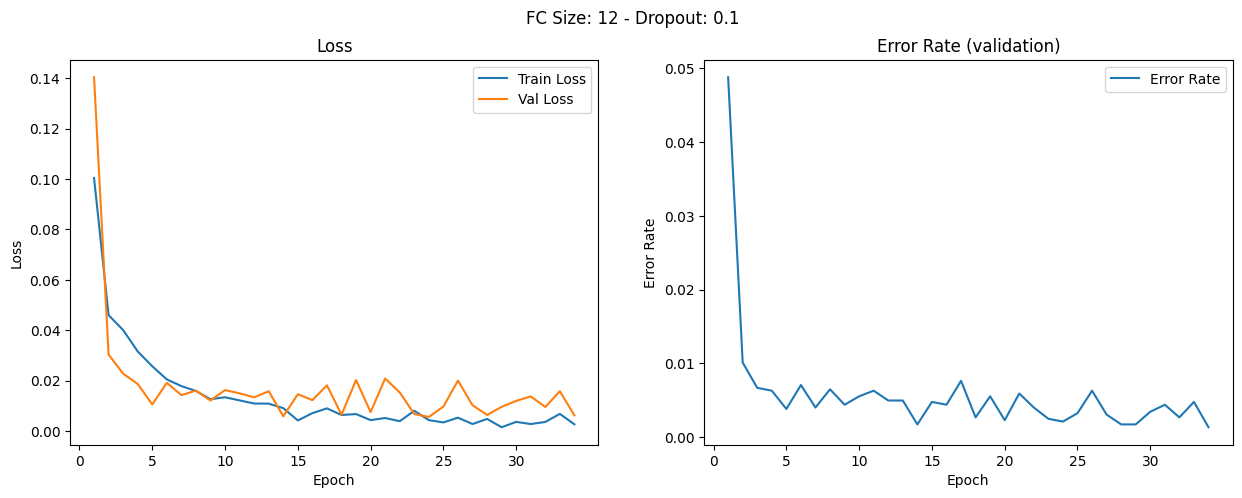

>>>>>>>>     FC Size: 24 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.0855 - Val Loss: 0.0356 - Error Rate: 0.0124 - F1 score : 0.9878


Epoch 2/100	 Train Loss: 0.0404 - Val Loss: 0.0211 - Error Rate: 0.0086 - F1 score : 0.9915


Epoch 3/100	 Train Loss: 0.0287 - Val Loss: 0.0270 - Error Rate: 0.0095 - F1 score : 0.9906


Epoch 4/100	 Train Loss: 0.0251 - Val Loss: 0.0320 - Error Rate: 0.0135 - F1 score : 0.9867


Epoch 5/100	 Train Loss: 0.0208 - Val Loss: 0.0184 - Error Rate: 0.0080 - F1 score : 0.9921


Epoch 6/100	 Train Loss: 0.0149 - Val Loss: 0.0132 - Error Rate: 0.0046 - F1 score : 0.9955


Epoch 7/100	 Train Loss: 0.0156 - Val Loss: 0.0131 - Error Rate: 0.0046 - F1 score : 0.9955


Epoch 8/100	 Train Loss: 0.0186 - Val Loss: 0.0119 - Error Rate: 0.0044 - F1 score : 0.9957


Epoch 9/100	 Train Loss: 0.0097 - Val Loss: 0.0091 - Error Rate: 0.0036 - F1 score : 0.9964


Epoch 10/100	 Train Loss: 0.0096 - Val Loss: 0.0131 - Error Rate: 0.0050 - F1 score : 0.9951


Epoch 11/100	 Train Loss: 0.0079 - Val Loss: 0.0180 - Error Rate: 0.0065 - F1 score : 0.9935


Epoch 12/100	 Train Loss: 0.0073 - Val Loss: 0.0083 - Error Rate: 0.0034 - F1 score : 0.9966


Epoch 13/100	 Train Loss: 0.0054 - Val Loss: 0.0178 - Error Rate: 0.0051 - F1 score : 0.9949


Epoch 14/100	 Train Loss: 0.0080 - Val Loss: 0.0064 - Error Rate: 0.0030 - F1 score : 0.9970


Epoch 15/100	 Train Loss: 0.0051 - Val Loss: 0.0076 - Error Rate: 0.0025 - F1 score : 0.9975


Epoch 16/100	 Train Loss: 0.0063 - Val Loss: 0.0145 - Error Rate: 0.0044 - F1 score : 0.9957


Epoch 17/100	 Train Loss: 0.0060 - Val Loss: 0.0089 - Error Rate: 0.0030 - F1 score : 0.9970


Epoch 18/100	 Train Loss: 0.0049 - Val Loss: 0.0064 - Error Rate: 0.0021 - F1 score : 0.9979


Epoch 19/100	 Train Loss: 0.0038 - Val Loss: 0.0075 - Error Rate: 0.0027 - F1 score : 0.9974


Epoch 20/100	 Train Loss: 0.0045 - Val Loss: 0.0071 - Error Rate: 0.0021 - F1 score : 0.9979


Epoch 21/100	 Train Loss: 0.0057 - Val Loss: 0.0125 - Error Rate: 0.0038 - F1 score : 0.9962


Epoch 22/100	 Train Loss: 0.0029 - Val Loss: 0.0338 - Error Rate: 0.0093 - F1 score : 0.9908


Epoch 23/100	 Train Loss: 0.0034 - Val Loss: 0.0076 - Error Rate: 0.0019 - F1 score : 0.9981


Epoch 24/100	 Train Loss: 0.0041 - Val Loss: 0.0099 - Error Rate: 0.0030 - F1 score : 0.9970


Epoch 25/100	 Train Loss: 0.0041 - Val Loss: 0.0094 - Error Rate: 0.0030 - F1 score : 0.9970
Early stopping on epoch 25


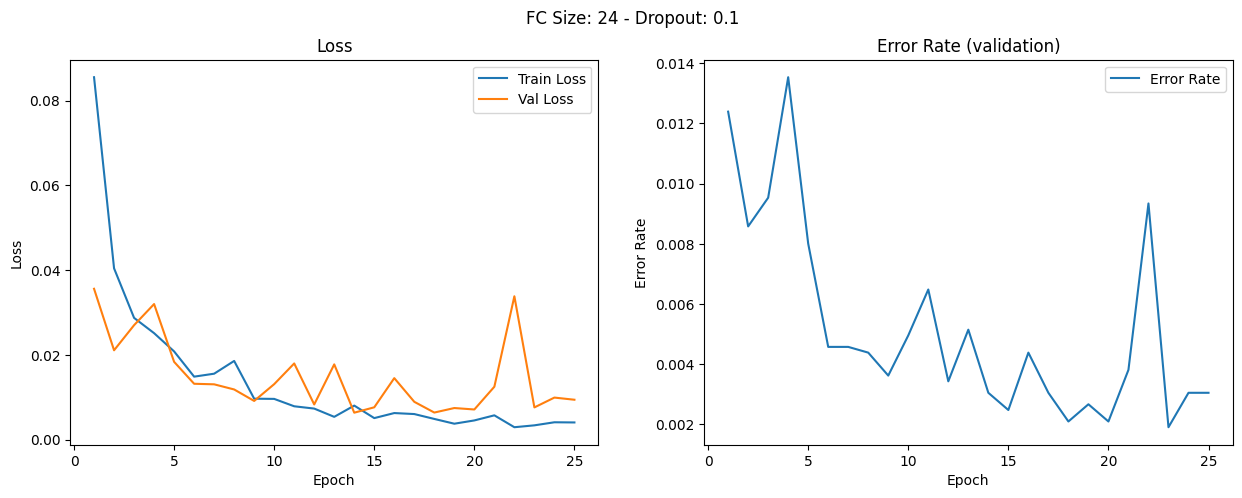

In [40]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

for fc_size in fc_sizes:
    for dropout in dropouts:
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=(epoch+1)%5==0, desc=f'TrainingEpoch{(epoch + 1):02d}', dir_checkpoint=f'custom/fc_{fc_size}_dropout_{dropout}')
            val_loss, errors, f1 = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f} - F1 score : {f1:.4f}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
        
        axs[0].title.set_text('Loss')
        axs[1].title.set_text('Error Rate (validation)')
        
        epochs = [i+1 for i in range(len(train_losses))]
        axs[0].plot(epochs, train_losses, label='Train Loss')
        axs[0].plot(epochs, val_losses, label='Val Loss')
        axs[1].plot(epochs, err_rates, label='Error Rate')
        
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        axs[0].set_xlabel('Epoch')
        axs[0].set_xticks(epochs)
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].set_xlabel('Epoch')
        axs[1].set_xticks(epochs)
        axs[1].set_ylabel('Error Rate')
        axs[1].legend()        

        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'custom')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}.png')
        
        fig.savefig(fig_path)